In [3]:
pip install torch

In [4]:
pip install torch_geometric

In [5]:
pip install igraph

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from igraph import Graph
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

In [7]:
import re
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.utils import from_scipy_sparse_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from scipy.sparse import csr_matrix
import pandas as pd

In [8]:
# Load dataset
file_path = '/content/Cleaned_dataset_new.csv'
df = pd.read_csv(file_path)


Eksplorasi Data

In [9]:
df.info()
df.dropna()
# Cek apakah ada NaN di kolom Tweet
df['Cleaned_Tweet'].isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13169 entries, 0 to 13168
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   sentiment        13169 non-null  object
 1   sentiment_label  13169 non-null  int64 
 2   Cleaned_Tweet    13128 non-null  object
dtypes: int64(1), object(2)
memory usage: 308.8+ KB


41

<ipython-input-10-b4a66a4b8c98>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df, palette='viridis')


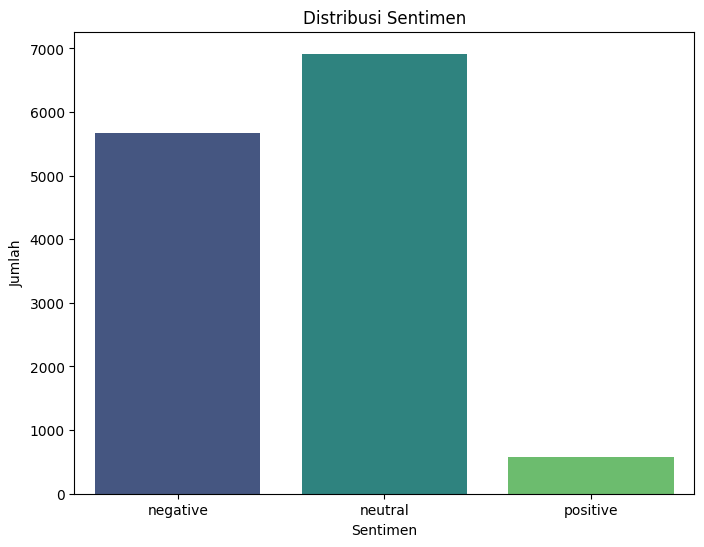

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualisasi distribusi sentimen dengan label positif, negatif, dan netral
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df, palette='viridis')
plt.title('Distribusi Sentimen')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.show()


In [11]:
# Menampilkan jumlah real dari setiap label sentimen
label_counts = df['sentiment'].value_counts()
print("Jumlah sampel per label sentimen:")
for label, count in label_counts.items():
    print(f"{label}: {count} sampel")

Jumlah sampel per label sentimen:
neutral: 6917 sampel
negative: 5669 sampel
positive: 583 sampel


In [12]:
# Perbaiki kolom 'Tweet'
df['Cleaned_Tweet'] = df['Cleaned_Tweet'].fillna('').astype(str)

# Tambahkan kolom panjang tweet
df['Tweet_length'] = df['Cleaned_Tweet'].apply(lambda x: len(x.split()))

       Cleaned_Tweet sentiment
count          13169     13169
unique         12931         3
top                    neutral
freq              41      6917


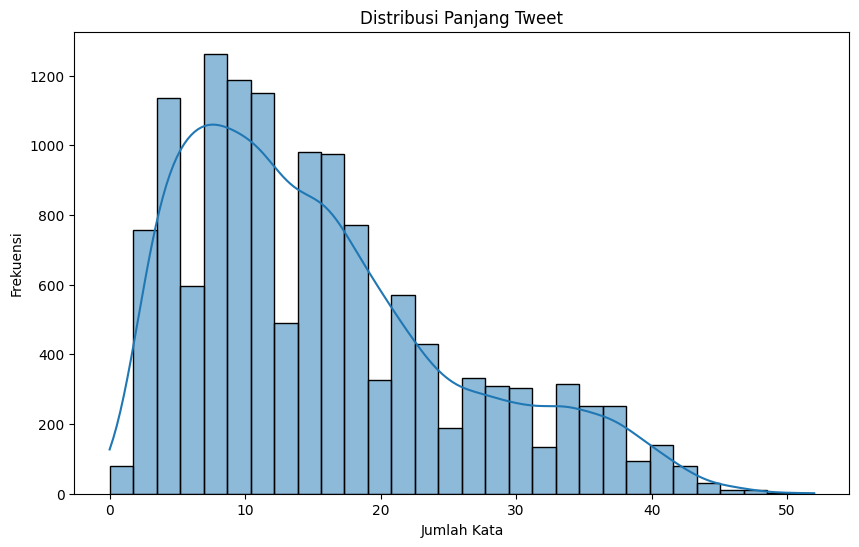

In [13]:
# Menampilkan statistik deskriptif dari kolom 'Tweet' dan 'sentiment'
print(df[['Cleaned_Tweet', 'sentiment']].describe())

# Menampilkan distribusi panjang tweet dalam dataset (jumlah kata per tweet)
df['Tweet_length'] = df['Cleaned_Tweet'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10,6))
sns.histplot(df['Tweet_length'], kde=True, bins=30)
plt.title('Distribusi Panjang Tweet')
plt.xlabel('Jumlah Kata')
plt.ylabel('Frekuensi')
plt.show()



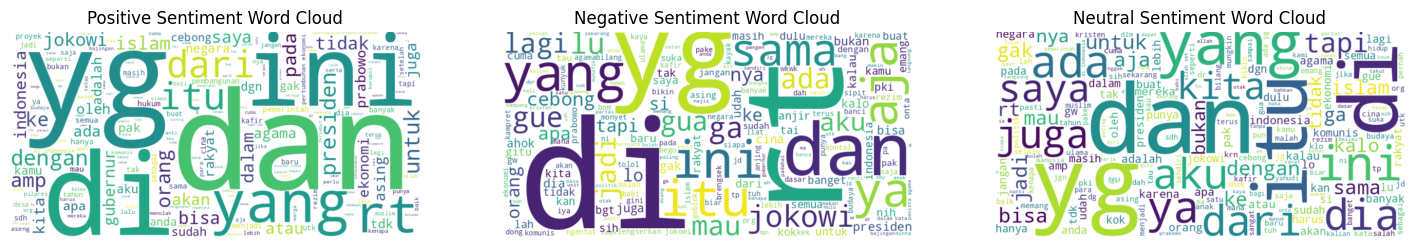

In [14]:
# Visualisasi word cloud untuk tweet dengan sentimen positif, negatif, dan netral
from wordcloud import WordCloud

# Filter tweet berdasarkan sentimen
positive_tweet = df[df['sentiment'] == 'positive']['Cleaned_Tweet']
negative_tweet = df[df['sentiment'] == 'negative']['Cleaned_Tweet']
neutral_tweet = df[df['sentiment'] == 'neutral']['Cleaned_Tweet']

# Membuat wordcloud untuk setiap sentimen
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(' '.join(positive_tweet))
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(' '.join(negative_tweet))
wordcloud_neutral = WordCloud(width=800, height=400, background_color='white').generate(' '.join(neutral_tweet))

# Plot wordcloud
plt.figure(figsize=(18, 6))
plt.subplot(131)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Positive Sentiment Word Cloud')
plt.axis('off')

plt.subplot(132)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Negative Sentiment Word Cloud')
plt.axis('off')

plt.subplot(133)
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.title('Neutral Sentiment Word Cloud')
plt.axis('off')

plt.show()

Graph Neural Network

In [15]:
# Label encoding untuk kolom sentimen
le = LabelEncoder()
df['sentiment_label'] = le.fit_transform(df['sentiment'])

# Pastikan semua data Tweet adalah string
df['Tweet'] = df['Cleaned_Tweet'].fillna('')

# Split data menjadi training dan testing
X = df['Tweet']
y = df['sentiment_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Menggunakan TF-IDF untuk vektorisasi hanya pada teks (Tweet)
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(X)

# Konversi ke array NumPy
X_features = X_tfidf.toarray()

# Membuat adjacency matrix berdasarkan cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(X_features)

In [16]:
# Threshold untuk adjacency matrix (hanya koneksi dengan similarity > threshold)
threshold = 0.5
adjacency_matrix = (similarity_matrix > threshold).astype(int)

# Konversi adjacency matrix menjadi edge index untuk PyTorch Geometric
edge_index = np.array(adjacency_matrix.nonzero(), dtype=np.int64)

# Membuat data PyTorch Geometric
data = Data(
    x=torch.tensor(X_features, dtype=torch.float),
    edge_index=torch.tensor(edge_index, dtype=torch.long),
    y=torch.tensor(y, dtype=torch.long)
)

# Split training dan testing berdasarkan indeks
train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)

train_indices = X_train.index
test_indices = X_test.index

train_mask[train_indices] = True
test_mask[test_indices] = True

data.train_mask = train_mask
data.test_mask = test_mask

In [17]:
# Definisikan model GCN
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Inisialisasi model, optimizer, dan loss function
model = GCN(input_dim=5000, hidden_dim=64, output_dim=len(le.classes_))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Training GNN
def train(data):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Fungsi untuk mendapatkan prediksi dan label asli
def evaluate_predictions(data):
    model.eval()
    with torch.no_grad():
        logits = model(data)
        pred = logits[data.test_mask].argmax(dim=1)
        true_labels = data.y[data.test_mask]

        # Konversi ke NumPy
        pred_np = pred.cpu().numpy()
        true_labels_np = true_labels.cpu().numpy()

        return pred_np, true_labels_np

# Loop training
for epoch in range(1, 201):  # 200 epochs
    loss = train(data)  # Fungsi train melatih model
    if epoch % 10 == 0:  # Cetak setiap 10 epoch
        print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}")

# Setelah pelatihan selesai
print("Final Evaluation on Test Data:")

# Dapatkan prediksi dan label asli
pred_np, true_labels_np = evaluate_predictions(data)

# Hitung metrik
accuracy = accuracy_score(true_labels_np, pred_np) * 100
precision = precision_score(true_labels_np, pred_np, average='weighted') * 100
recall = recall_score(true_labels_np, pred_np, average='weighted') * 100
f1 = f1_score(true_labels_np, pred_np, average='weighted') * 100

# Cetak hasil evaluasi
print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1 Score: {f1:.2f}%")


Epoch: 010, Loss: 0.0499
Epoch: 020, Loss: 0.0492
Epoch: 030, Loss: 0.0485
Epoch: 040, Loss: 0.0479
Epoch: 050, Loss: 0.0473
Epoch: 060, Loss: 0.0467
Epoch: 070, Loss: 0.0461
Epoch: 080, Loss: 0.0456
Epoch: 090, Loss: 0.0451
Epoch: 100, Loss: 0.0446
Epoch: 110, Loss: 0.0441
Epoch: 120, Loss: 0.0437
Epoch: 130, Loss: 0.0433
Epoch: 140, Loss: 0.0428
Epoch: 150, Loss: 0.0425
Epoch: 160, Loss: 0.0421
Epoch: 170, Loss: 0.0417
Epoch: 180, Loss: 0.0413
Epoch: 190, Loss: 0.0410
Epoch: 200, Loss: 0.0407
Final Evaluation on Test Data:
Accuracy: 60.93%
Precision: 60.85%
Recall: 60.93%
F1 Score: 60.88%
